In [1]:
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Flatten,Dense,Dropout
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os

In [2]:
IMG_SIZE = 150
lr = 0.001
categories = ["cat","dog"]

In [3]:
pre_trained_model = InceptionV3(include_top = False,weights = 'imagenet',input_shape = (IMG_SIZE,IMG_SIZE,3))
for layer in pre_trained_model.layers:
    layer.trainable = False

In [4]:
output_layer = pre_trained_model.get_layer('mixed7')
last_output = output_layer.output

In [5]:
x = Flatten()(last_output)
x = Dense(128,activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(2,activation = 'softmax')(x)

In [6]:
model = Model(pre_trained_model.input,x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

Add the absolute paths to the Training, Validation and Test directories to TRAIN_DIR, VAL_DIR, and TEST_DIR respectively.

In [7]:
TRAIN_DIR = r''
VAL_DIR = r''
TEST_DIR = r''

In [8]:
train_datagen = ImageDataGenerator(rescale = 1.0/255)
val_datagen = ImageDataGenerator(rescale = 1.0/255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size = 10,
    class_mode = 'categorical',
    target_size = (150,150)
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    batch_size = 10,
    class_mode = 'categorical',
    target_size = (150,150)
)

Found 18750 images belonging to 2 classes.
Found 6250 images belonging to 2 classes.


In [9]:
model.compile(optimizer = keras.optimizers.RMSprop(lr = lr),loss = 'categorical_crossentropy',metrics = ['acc'])

In [10]:
history = model.fit(train_gen,validation_data = val_gen,epochs = 4)

Epoch 1/4
1875/1875 [==============================] - 417s 223ms/step - loss: 0.2397 - acc: 0.9445 - val_loss: 0.1046 - val_acc: 0.9701
Epoch 2/4
1875/1875 [==============================] - 388s 207ms/step - loss: 0.1353 - acc: 0.9675 - val_loss: 0.1290 - val_acc: 0.9637
Epoch 3/4
1875/1875 [==============================] - 396s 211ms/step - loss: 0.0929 - acc: 0.9793 - val_loss: 0.1143 - val_acc: 0.9717
Epoch 4/4
1875/1875 [==============================] - 392s 209ms/step - loss: 0.0590 - acc: 0.9861 - val_loss: 0.1693 - val_acc: 0.9715


In [11]:
# model = keras.models.load_model('Final Model.h5')

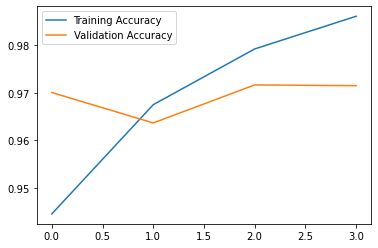

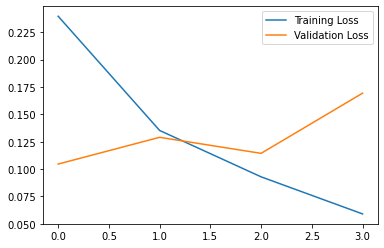

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = [i for i in range(len(acc))]
plt.plot(epochs,acc,label = 'Training Accuracy')
plt.plot(epochs,val_acc,label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.plot(epochs,loss,label = 'Training Loss')
plt.plot(epochs,val_loss,label = 'Validation Loss')
plt.legend()
plt.show()

In [12]:
model.save('Final Model.h5')
model.save_weights('Model Weight.h5')

In [17]:
ans = []
for file_name in tqdm(range(1,12501)):
    file_path = os.path.join(TEST_DIR,'test')
    file_path = os.path.join(file_path,str(file_name)+'.jpg')
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img/255
    img = np.expand_dims(img,axis = 0)
    ans.append([file_name,model.predict(img)])

100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [09:00<00:00, 23.13it/s]


In [18]:
for i in range(len(ans)):
    ans[i][1] = ans[i][1][0][1]

In [19]:
ans_df = pd.DataFrame(ans,columns = ['id','label'])
ans_df.to_csv("Final Submission.csv",index = False)

I now sample the first 10 pictures to see how the model performed.

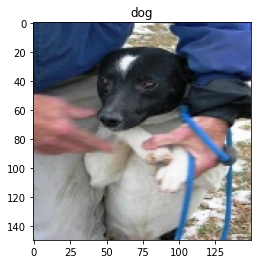

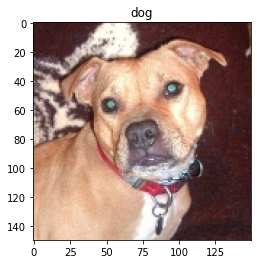

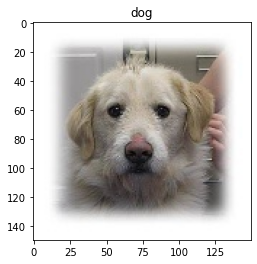

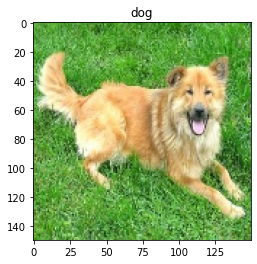

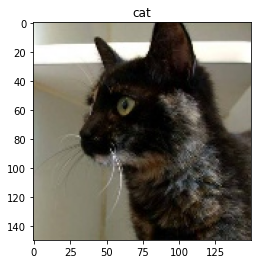

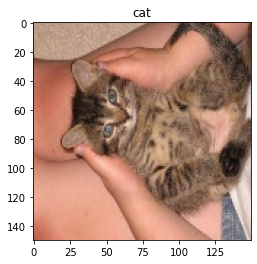

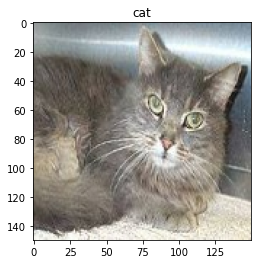

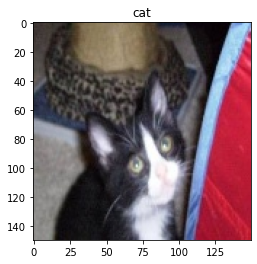

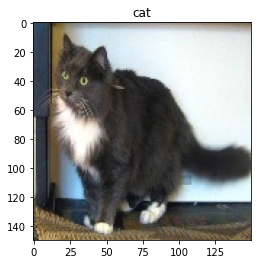

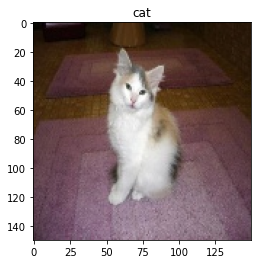

In [20]:
for index in range(1,11):
    file_path = os.path.join(TEST_DIR,'test')
    file_path = os.path.join(file_path,str(index)+'.jpg')
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img/255
    plt.imshow(img)
    test_y = model.predict(np.expand_dims(img,axis = 0))
    plt.title(label = categories[np.argmax(test_y[0])])
    plt.show()